# Data Modeling:

## Regression model with target feature price 

Now that we have a clean dataframe with no multicollinearity, we can attempt to create models. 

## Summary:
* All models use price_log as target variable.
* Model 1 includes all features.
* Model 2 includes all features with categorical outliers removed. 
* Model 3 includes the top 4 features that correlate highest with price_log. Simple model attempt. 

**Main Goals for model fitting:**
* Fit an intial regression model. Using statistical analysis look at the p-value of features and determine which features are important and which are not statistically significant.
* Test for normality. 
* Test for heteroscedasticity.  
* From the tests we can evaluate the performance of our models.

In [10]:
#import all neccesary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('seaborn')

import statsmodels.api as sm
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

There are 3 main assumptions for regression models: 

**Linearity:** 
* There needs to be a linear relationship between the target variable and the predictors being used. 

**Normality:** 
* The residual erros from the model are to be assumed as normally distributed. This can be checked using a Qunatile-Quantile Plot. 

**Homoscedasticity:** 
* The residual erros from the model should not be correlated with the target variable or any predictors. This can be viewed through a residual plot. The erros must bve random. 

In [11]:
# read cleaned dataframe
clean = pd.read_csv('../data/clean.csv', index_col=0)
clean.head()

,price_log,sqft_lot_log,sqft_above_log,bedrooms,bathrooms,floors,condition_num,extracted_grade_num,waterfront_1,greenbelt_1,...,zipcode_90.0,zipcode_91.0,zipcode_92.0,zipcode_93.0,zipcode_94.0,zipcode_95.0,zipcode_96.0,zipcode_97.0,zipcode_98.0,zipcode_99.0
21177,12.422989,10.591823,7.489971,3,1.5,1.0,4,7,0,0,...,0,0,0,0,0,0,0,0,0,0
10844,13.319574,9.462343,7.710653,4,1.5,1.5,4,7,0,0,...,0,0,0,0,0,0,0,0,0,0
9292,13.835313,9.626152,7.229839,5,2.0,1.0,4,8,0,0,...,0,0,0,0,0,0,0,0,0,0
17878,13.321214,9.651945,7.098376,5,2.0,1.0,3,7,0,0,...,0,0,0,0,0,0,0,0,0,0
14450,13.458836,9.061840,7.450080,3,2.0,1.5,5,7,0,0,...,0,0,0,0,0,0,0,0,0,0


## Model 1 with with all features included and target variable price_log

In [12]:
# Specify the model parameters
X = clean.drop(labels='price_log', axis=1)
y = clean['price_log']

# Create model
model1 = sm.OLS(y, sm.add_constant(X))
model1_results = model1.fit()
print(model1_results.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     197.4
Date:                Sat, 29 Jul 2023   Prob (F-statistic):               0.00
Time:                        10:40:28   Log-Likelihood:                -8322.2
No. Observations:               30110   AIC:                         1.735e+04
Df Residuals:                   29758   BIC:                         2.027e+04
Df Model:                         351                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      9

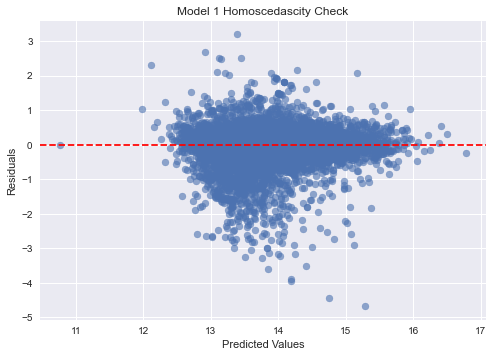

In [13]:
# View model predictions
predicted_values = model1_results.fittedvalues
residuals = model1_results.resid

# Generate the residual plot
fig, ax = plt.subplots()
ax.scatter(predicted_values, residuals, alpha=0.6)
ax.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Model 1 Homoscedascity Check')
plt.grid(True)
plt.show()

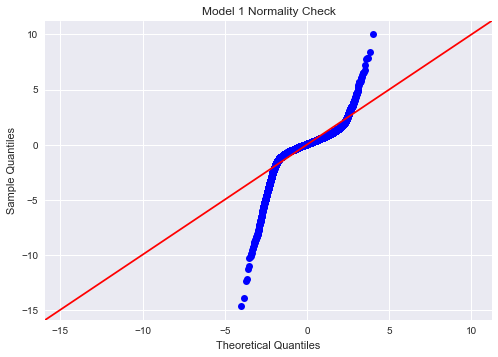

In [14]:
sm.graphics.qqplot(model1_results.resid, dist=stats.norm, line='45', fit=True)
plt.title("Model 1 Normality Check")
plt.show()

In [15]:
# Get the predictions from the fitted model
predictions = model1_results.predict(sm.add_constant(X))

# Step 3: Calculate the squared differences between predicted and actual values
squared_errors = (y - predictions) ** 2

# Step 4: Calculate the mean of the squared differences
mean_squared_error = np.mean(squared_errors)

# Step 5: Take the square root to get the RMSE
rmse = np.sqrt(mean_squared_error)

print("Root Mean Square Error (RMSE):", rmse)
print(f"Model Predictions are off by a factor of {round(np.exp(rmse),2)} times the actual price.")

Root Mean Square Error (RMSE): 0.3190063507196301
Model Predictions are off by a factor of 1.38 times the actual price.


**Observations:**
* Overall the model is statistically significant with the F-statistic p-value less than 0.05.
* The model explains about 70% percent of the variance in price_log
* There are non statistically significant features that include some of the zipcodes, bedrooms, garage 1.0, heat_Gas/Oil
* The model dooes not seem to have a normal distribution despite log transformation and standardizing the continous data in the data_preparation process. 
* The model does well in only a certain range of values which probably explains the MSE value which is close to zero. 
* There are outliers as we can see in the residual plot. 
* The residuals however show Heteroscedascity which is not good. It should be have a behavior known as Homoscedascity where the data is randmonly scattered.
* The models predictions according to the RMSE are off by a factor of 1.38 times the actual price prediction. 

Eliminate any features above 0.05 p-value as these features are considered not significant for the model. 

In [16]:
import pandas as pd
import statsmodels.api as sm

# Specify the model parameters
X = clean.drop(labels='price_log', axis=1)
y = clean['price_log']

# Fit the initial model
model = sm.OLS(y, sm.add_constant(X)).fit()

# Continue the loop while there are high p-values
while model.pvalues.drop('const').max() > 0.05:
    # Extract feature names and corresponding p-values
    feature_p_values = model.pvalues.drop('const')  # Drop the intercept p-value
    
    # Filter features with p-values > 0.05
    features_with_high_p_value = feature_p_values[feature_p_values > 0.05]
    
    # Remove features with high p-values from the dataset
    features_to_drop = features_with_high_p_value.index.intersection(X.columns)
    X = X.drop(features_to_drop, axis=1)
    
    # Fit the updated model
    X = sm.add_constant(X)  # Add the constant column again
    model = sm.OLS(y, X).fit()

In [17]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     622.7
Date:                Sat, 29 Jul 2023   Prob (F-statistic):               0.00
Time:                        10:40:30   Log-Likelihood:                -8433.0
No. Observations:               30110   AIC:                         1.709e+04
Df Residuals:                   29998   BIC:                         1.802e+04
Df Model:                         111                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      9

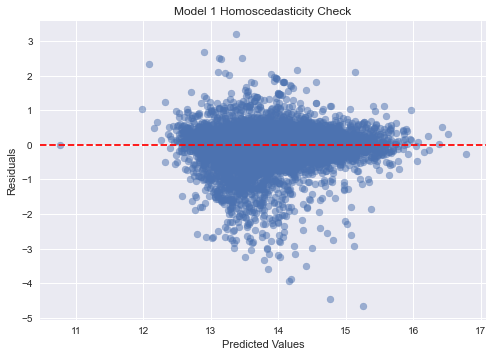

In [18]:
# View model predictions
predicted_values = model.fittedvalues
residuals = model.resid

# Generate the residual plot
fig, ax = plt.subplots()
ax.scatter(predicted_values, residuals, alpha=0.5)
ax.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Model 1 Homoscedasticity Check')
plt.grid(True)
plt.show()

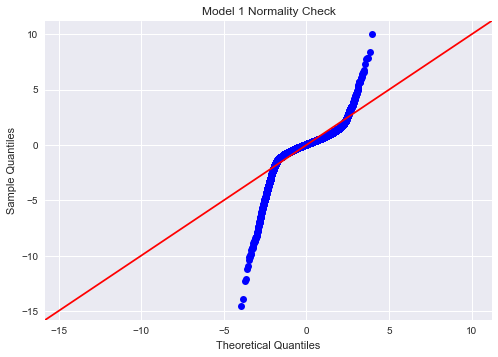

In [19]:
sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.title("Model 1 Normality Check")
plt.show()

In [21]:
# Get the predictions from the fitted model
predictions = model.predict(sm.add_constant(X))

# Step 3: Calculate the squared differences between predicted and actual values
squared_errors = (y - predictions) ** 2

# Step 4: Calculate the mean of the squared differences
mean_squared_error = np.mean(squared_errors)

# Step 5: Take the square root to get the RMSE
rmse = np.sqrt(mean_squared_error)

print("Root Mean Square Error (RMSE):", rmse)
print(f"Model Predictions are off by a factor of {round(np.exp(rmse),2)} times the actual price.")

Root Mean Square Error (RMSE): 0.32018251682706217
Model Predictions are off by a factor of 1.38 times the actual price.


**Observations:**
* Overall the model is statistically significant with the F-statistic p-value less than 0.05.
* The model explains about 70% percent of the variance in price_log.
* The model dooes not seem to have a normal distribution despite log transformation and standardizing the continous data in the data_preparation process. 
* The model does well in only a certain range of values which probably explains the MSE value which is close to zero. 
* There are outliers as we can see in the residual plot. The kurtosis value also suggets outliers as well. 
* The residuals however show Heteroscedascity which is not good. It should be have a behavior known as Homoscedascity where the data is randmonly scattered.


## Model 2 (Removed Outliers from Categorical Variables)

In the data preprocessing we removed outliers in the continuous variables however we did not do so for categorical variables. The main reason was to account for all category values. Lets see if doing so improves the moodel. 

Remove outliers 3 standard deviations away from mean

In [76]:
for col in clean.columns:
    print(col)

price_log
sqft_lot_log
sqft_above_log
bedrooms
bathrooms
floors
condition_num
extracted_grade_num
waterfront_1
greenbelt_1
basement_1.0
garage_1.0
patio_1.0
sewer_PUBLIC
heat_Electricity/Solar
heat_Gas
heat_Gas/Solar
heat_Oil
zipcode_0.0
zipcode_1.0
zipcode_10.0
zipcode_100.0
zipcode_101.0
zipcode_102.0
zipcode_103.0
zipcode_104.0
zipcode_105.0
zipcode_106.0
zipcode_107.0
zipcode_108.0
zipcode_109.0
zipcode_11.0
zipcode_110.0
zipcode_111.0
zipcode_112.0
zipcode_113.0
zipcode_114.0
zipcode_115.0
zipcode_116.0
zipcode_117.0
zipcode_118.0
zipcode_119.0
zipcode_12.0
zipcode_120.0
zipcode_121.0
zipcode_122.0
zipcode_123.0
zipcode_124.0
zipcode_125.0
zipcode_126.0
zipcode_127.0
zipcode_128.0
zipcode_129.0
zipcode_13.0
zipcode_130.0
zipcode_131.0
zipcode_132.0
zipcode_133.0
zipcode_134.0
zipcode_135.0
zipcode_136.0
zipcode_137.0
zipcode_138.0
zipcode_139.0
zipcode_14.0
zipcode_140.0
zipcode_141.0
zipcode_142.0
zipcode_143.0
zipcode_144.0
zipcode_145.0
zipcode_146.0
zipcode_147.0
zipcode_148.0

In [22]:
cat_removed_out = clean.copy()

import numpy as np

# Create subset of columns
columns_of_interest = ['bedrooms', 'bathrooms', 'floors', 'condition_num', 'extracted_grade_num']

# Define a function to remove outliers from a specific column 3 std away from mean
def remove_outliers(df, column_name, cutoff=3):
    mean = np.mean(df[column_name])
    std = np.std(df[column_name])
    cut_off = std * cutoff
    
    # Find outliers
    outliers = df[abs(df[column_name] - mean) >= cut_off]
    # Count the number of outliers removed
    num_outlier_removed = len(outliers)
    # Drop outlier from dataframe
    df.drop(outliers.index, inplace=True)
    
    return df, num_outlier_removed 

# Create a dictionary so we can inspect how many outliers were removed per column
outliers_removed_count = {}

# Loop through the columns of interest and remove outliers
for col in columns_of_interest:
    cat_removed_out, num_outliers_removed = remove_outliers(cat_removed_out, col)
    outliers_removed_count[col] = num_outliers_removed

print(outliers_removed_count)

cat_removed_out.head()

{'bedrooms': 176, 'bathrooms': 310, 'floors': 44, 'condition_num': 59, 'extracted_grade_num': 455}


,price_log,sqft_lot_log,sqft_above_log,bedrooms,bathrooms,floors,condition_num,extracted_grade_num,waterfront_1,greenbelt_1,...,zipcode_90.0,zipcode_91.0,zipcode_92.0,zipcode_93.0,zipcode_94.0,zipcode_95.0,zipcode_96.0,zipcode_97.0,zipcode_98.0,zipcode_99.0
21177,12.422989,10.591823,7.489971,3,1.5,1.0,4,7,0,0,...,0,0,0,0,0,0,0,0,0,0
10844,13.319574,9.462343,7.710653,4,1.5,1.5,4,7,0,0,...,0,0,0,0,0,0,0,0,0,0
9292,13.835313,9.626152,7.229839,5,2.0,1.0,4,8,0,0,...,0,0,0,0,0,0,0,0,0,0
17878,13.321214,9.651945,7.098376,5,2.0,1.0,3,7,0,0,...,0,0,0,0,0,0,0,0,0,0
14450,13.458836,9.061840,7.450080,3,2.0,1.5,5,7,0,0,...,0,0,0,0,0,0,0,0,0,0


Create a model with this new dataframe.

In [23]:
# Specify the model parameters
X = cat_removed_out.drop(labels='price_log', axis=1)
y = cat_removed_out['price_log']

# Create model
model2 = sm.OLS(y, sm.add_constant(X))
model2_results = model1.fit()
print(model2_results.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     197.4
Date:                Sat, 29 Jul 2023   Prob (F-statistic):               0.00
Time:                        10:40:53   Log-Likelihood:                -8322.2
No. Observations:               30110   AIC:                         1.735e+04
Df Residuals:                   29758   BIC:                         2.027e+04
Df Model:                         351                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      9

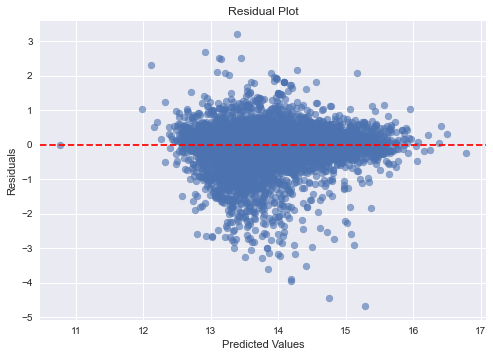

In [79]:
# View model predictions
predicted_values = model2_results.fittedvalues
residuals = model2_results.resid

# Generate the residual plot
fig, ax = plt.subplots()
ax.scatter(predicted_values, residuals, alpha=0.6)
ax.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Residual Plot')
plt.grid(True)
plt.show()

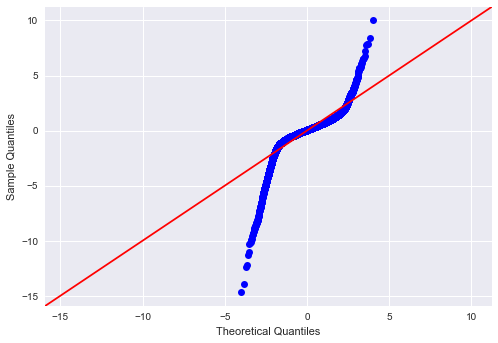

In [80]:
sm.graphics.qqplot(model2_results.resid, dist=stats.norm, line='45', fit=True)
plt.show()

In [24]:
# Get the predictions from the fitted model
predictions = model2_results.predict(sm.add_constant(X))

# Step 3: Calculate the squared differences between predicted and actual values
squared_errors = (y - predictions) ** 2

# Step 4: Calculate the mean of the squared differences
mean_squared_error = np.mean(squared_errors)

# Step 5: Take the square root to get the RMSE
rmse = np.sqrt(mean_squared_error)

print("Root Mean Square Error (RMSE):", rmse)
print(f"Model Predictions are off by a factor of {round(np.exp(rmse),2)} times the actual price.")

Root Mean Square Error (RMSE): 0.31498158798419584
Model Predictions are off by a factor of 1.37 times the actual price.


In [25]:
import pandas as pd
import statsmodels.api as sm

# Specify the model parameters
X = cat_removed_out.drop(labels='price_log', axis=1)
y = cat_removed_out['price_log']

# Fit the initial model
model = sm.OLS(y, sm.add_constant(X)).fit()

# Continue the loop while there are high p-values
while model.pvalues.drop('const').max() > 0.05:
    # Extract feature names and corresponding p-values
    feature_p_values = model.pvalues.drop('const')  # Drop the intercept p-value
    
    # Filter features with p-values > 0.05
    features_with_high_p_value = feature_p_values[feature_p_values > 0.05]
    
    # Remove features with high p-values from the dataset
    features_to_drop = features_with_high_p_value.index.intersection(X.columns)
    X = X.drop(features_to_drop, axis=1)
    
    # Fit the updated model
    X = sm.add_constant(X)  # Add the constant column again
    model = sm.OLS(y, X).fit()

In [26]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     536.8
Date:                Sat, 29 Jul 2023   Prob (F-statistic):               0.00
Time:                        10:41:44   Log-Likelihood:                -7765.9
No. Observations:               29066   AIC:                         1.575e+04
Df Residuals:                   28958   BIC:                         1.664e+04
Df Model:                         107                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      9

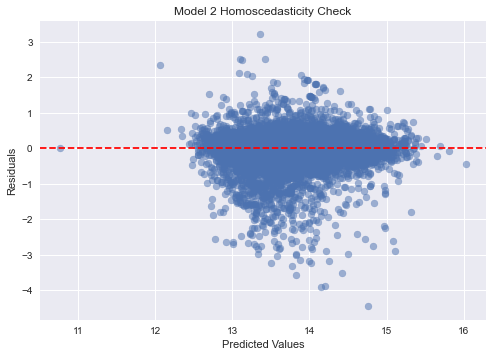

In [84]:
# View model predictions
predicted_values = model.fittedvalues
residuals = model.resid

# Generate the residual plot
fig, ax = plt.subplots()
ax.scatter(predicted_values, residuals, alpha=0.5)
ax.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Model 2 Homoscedasticity Check')
plt.grid(True)
plt.show()

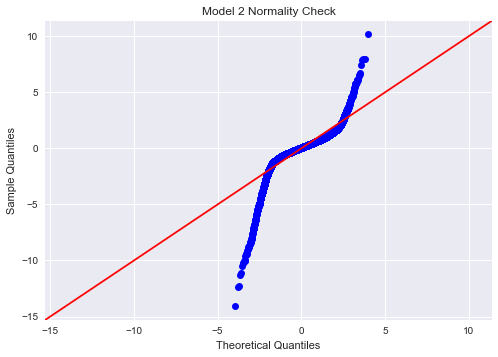

In [85]:
sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.title("Model 2 Normality Check")
plt.show()

In [27]:
# Get the predictions from the fitted model
predictions = model.predict(sm.add_constant(X))

# Step 3: Calculate the squared differences between predicted and actual values
squared_errors = (y - predictions) ** 2

# Step 4: Calculate the mean of the squared differences
mean_squared_error = np.mean(squared_errors)

# Step 5: Take the square root to get the RMSE
rmse = np.sqrt(mean_squared_error)

print("Root Mean Square Error (RMSE):", rmse)
print(f"Model Predictions are off by a factor of {round(np.exp(rmse),2)} times the actual price.")

Root Mean Square Error (RMSE): 0.31608130723734723
Model Predictions are off by a factor of 1.37 times the actual price.


**Observations:**
* Removing outliers from the categorical variables did not change the model much in comparison to our first model. 
* Overall the model is statistically significantly with a F-statistic p-value below 0.05
* The model explains about 65% percent of the variance in price_log.
* The model dooes not seem to have a normal distribution despite log transformation and standardizing the continous data in the data_preparation process. 
* The model does well in only a certain range of values which probably explains the MSE value which is close to zero. 
* There are outliers as we can see in the residual plot. The kurtosis value also suggets outliers as well. 
* Eventhough we preserved about 98% of the data representation by removing outliers 3 standard deviations away there continues to be outliers.
* The residuals however show Heteroscedascity which is not good. It should be have a behavior closer to Homoscedascity where the data is randmonly scattered.


## Model 3 with top 4 features

Model 1 has a lot of features so that being said lets see if we can still capture most of the variance and on top of that use less features.

In [28]:
# Identify top 3 features
clean.corr()["price_log"].sort_values(ascending=False)

price_log              1.000000
extracted_grade_num    0.614471
sqft_above_log         0.522001
bathrooms              0.516526
bedrooms               0.345930
                         ...   
zipcode_13.0          -0.115221
zipcode_3.0           -0.118008
zipcode_17.0          -0.118891
zipcode_24.0          -0.119903
zipcode_0.0           -0.135357
Name: price_log, Length: 352, dtype: float64

In [29]:
# Specify the model parameters
X = clean[['extracted_grade_num', 'sqft_above_log', 'bathrooms', 'bedrooms']]
y = clean['price_log']

# Make Model 3
model3 = sm.OLS(y, sm.add_constant(X))
model3_results = model3.fit()
print(model3_results.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     5226.
Date:                Sat, 29 Jul 2023   Prob (F-statistic):               0.00
Time:                        10:42:30   Log-Likelihood:                -18487.
No. Observations:               30110   AIC:                         3.698e+04
Df Residuals:                   30105   BIC:                         3.703e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.7053    

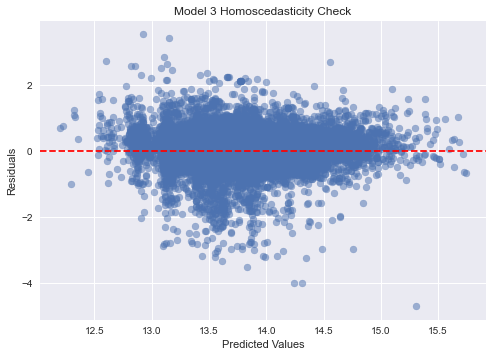

In [30]:
# View model predictions
predicted_values = model3_results.fittedvalues
residuals = model3_results.resid

# Generate the residual plot
fig, ax = plt.subplots()
ax.scatter(predicted_values, residuals, alpha=0.5)
ax.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Model 3 Homoscedasticity Check')
plt.grid(True)
plt.show()

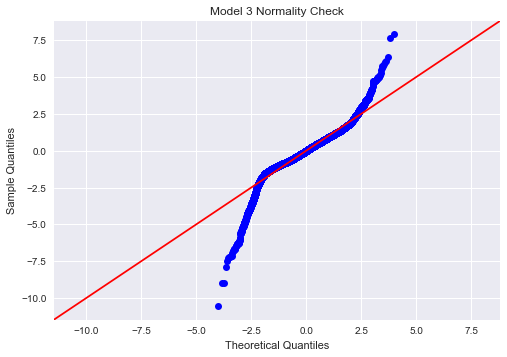

In [90]:
sm.graphics.qqplot(model3_results.resid, dist=stats.norm, line='45', fit=True)
plt.title("Model 3 Normality Check")
plt.show()

In [33]:
# Get the predictions from the fitted model
predictions = model3_results.predict(sm.add_constant(X))

# Step 3: Calculate the squared differences between predicted and actual values
squared_errors = (y - predictions) ** 2

# Step 4: Calculate the mean of the squared differences
mean_squared_error = np.mean(squared_errors)

# Step 5: Take the square root to get the RMSE
rmse = np.sqrt(mean_squared_error)

print("Root Mean Square Error (RMSE):", rmse)
print(f"Model Predictions are off by a factor of {round(np.exp(rmse),2)} times the actual price.")

Root Mean Square Error (RMSE): 0.4471105062962519
Model Predictions are off by a factor of 1.56 times the actual price.


**Observations:** 
* The model overall is statistically significant with a F-statistic p-value less than 0.05.
* All features are statistically significant.
* The model describes about 40% of the variance in price_log. 
* It seems that excluding the zipcode/location of a home significantly impacted the prediction of price_log.
* Model predictions are off by a factor of 1.56 timees the actual price. 
* The residuals however show Heteroscedascity which is not good. It should be have a behavior closer to Homoscedascity where the data is randmonly scattered.